In [61]:
#In this code I have fit a SVM model on the Loans Dataset. Below are the steps that I have used in the process.
#1. Imported the dataset and filtered only the 36 months records for further analysis.
#2. On initial review, removed the unecessary columns such as dates, descriptions, urls etc. (Please see the comments against the code)
#3. Used an encoding technique to encode all the factors to int's ( grade , emp_length etc ).
#4. Printed the intitial ratio for the (Target = 1 / Total observations) to see if I need to use a stratified sampling approach
#5. Substituted all the Nan's in the dataframe to -1.  We Could use better techniques such as mean/median/Regression.
#6. Normalized the columns since all the predictor variables had different range of values.
#7. Now, we are ready with the data i.e our X matrix and the Y matrix which contains the actual values.
#8. Just to see what percentile of the features we need to included I plotted a graph for the Percentile Features Vs the Prediction Rate.
#9. From Point 8. I got the Percentile values as 10%. Thus I proceeded with this perent of features.
#10. Used the Feature selection technique with 10% features from the scrubbed X matrix.
#11. Fit a SVM model to see which are the features that we need to use for prediction.
#12. Used a K-Cross fold validation with a stratified sampling approach since the target variables had very few proportions of '1' than '0' 
#13. One more advantage that stratified sampling had was that it reduced the bias when a set of data was selected for crossvalidation.
#14. Plotted a Confusion matrix after fitting the model for review.
#==================================***********************************========================================

In [ ]:
#Importting the necessary libraries
import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import svm,  feature_selection, cross_validation
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn import metrics
%matplotlib inline


In [2]:
#Reading the file into a data frame.
data_df = pd.read_csv('loan3b.csv')
sample = data_df.copy()

In [3]:
#Filtering the dataset by keeping only the 36 months records.
data_df = data_df[(data_df['term'] == " 36 months")]

#Populating the Target variable.
def populate_target(row):
    if row['loan_status'] == 'Fully Paid':
        return 1
    else:
        return 0
#Calling the populate_target function to populate the target variable.
data_df['target'] = data_df.apply (lambda row: populate_target (row),axis=1)        

In [4]:
print "Intitial Shape is :",(data_df.shape)

Intitial Shape is : (143850, 101)


In [5]:
#Creating a label encoder object for encoding the various strings to int (Factors)
label_encoder = preprocessing.LabelEncoder()
#ON initial analysis, removing these variables from the dataset since they either contain dates/ descriptions / urls which did not seem inportant.
data_df.drop(['title','term','accept_d','issue_d','exp_d' ,'url','desc','earliest_cr_line','last_pymnt_d' , 'next_pymnt_d' , 'last_credit_pull_d','emp_title'], axis=1, inplace=True)

In [6]:
data_df.drop(['list_d'], axis=1, inplace=True)

In [7]:
data_df.drop(['id' , 'member_id'], axis=1, inplace=True)

In [8]:
print "After removing the above columns , the shape is : " , data_df.shape

#data_df['int_rate'] = label_encoder.fit_transform(data_df['int_rate'])
#data_df.shape

After removing the above columns , the shape is :  (143850, 86)


In [9]:
#Removing the % sign from the int_rate variable.
data_df['int_rate'] = data_df['int_rate'].str.lstrip('+-').str.rstrip('%')
#data_df['int_rate'].head()
#Encoding the following variables.
data_df['grade'] = label_encoder.fit_transform(data_df['grade'])
#data_df['grade'].head()
data_df['sub_grade'] = label_encoder.fit_transform(data_df['sub_grade'])

In [10]:
data_df['emp_length'] = label_encoder.fit_transform(data_df['emp_length'])
data_df['home_ownership'] = label_encoder.fit_transform(data_df['home_ownership'])
data_df['is_inc_v'] = label_encoder.fit_transform(data_df['is_inc_v'])
data_df['loan_status'] = label_encoder.fit_transform(data_df['loan_status'])
data_df['pymnt_plan'] = label_encoder.fit_transform(data_df['pymnt_plan'])

In [11]:
data_df['purpose'] = label_encoder.fit_transform(data_df['purpose'])
data_df['addr_city'] = label_encoder.fit_transform(data_df['addr_city'])
data_df['addr_state'] = label_encoder.fit_transform(data_df['addr_state'])

In [12]:
data_df['revol_util'] = data_df['revol_util'].str.lstrip('+-').str.rstrip('%')
#print data_df['revol_util'].head()

In [13]:
data_df['initial_list_status'] = label_encoder.fit_transform(data_df['initial_list_status'])

In [14]:
y = data_df['target'].as_matrix().astype(np.int)


In [15]:
print('Target var 1:{} instances and Target var 0:{} instances.'.format(y.sum(),y.shape[0]-y.sum()))
print('Ratio of target var 1 over all the instances: {:.2f}'.format(float(y.sum())/y.shape[0] ))
data_df.shape

Target var 1:21913 instances and Target var 0:121937 instances.
Ratio of target var 1 over all the instances: 0.15


(143850, 86)

In [16]:
#Encoding all the NAN's as -1. 
def susbtitute_nan(x):
    if pd.isnull(x):
        return (-1)
    else:
        return x
data_df = data_df.applymap(susbtitute_nan)  

In [18]:
X = data_df[data_df.columns[0:85]].as_matrix().astype(np.float)
y = data_df['target'].as_matrix().astype(np.int)

In [21]:
#Since the data in X is such that it has different ranges of data. Thus I am normalizing it.
#Creating a scaler object
scaler = preprocessing.StandardScaler()

In [24]:
#Normalizing the X matrix.
X = scaler.fit_transform(X)
transform = feature_selection.SelectPercentile(feature_selection.f_classif)
clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

/root/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [84] are constant.
  UserWarning)


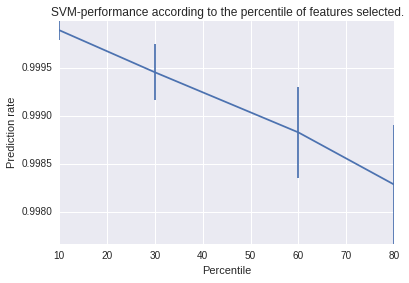

In [25]:
#I have commented this code since it takes a lot of time to iterate over the percentiles. Please see the plot 
#below for the different percentiles that I have plotted. I got 10% as the best estimate for percentile features.
'''score_means = list()
score_stds = list()
percentiles = (10, 30,60,80)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Computing  the cross-validation score.
    this_scores = cross_validation.cross_val_score(clf, X, y, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('SVM-performance according to the percentile of features selected.')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')
plt.axis('tight')
plt.show()
'''

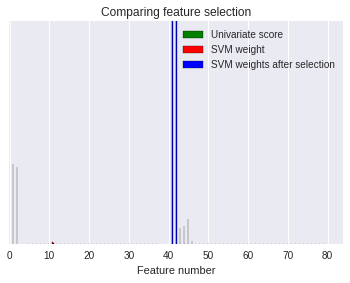

In [26]:
plt.figure(1)
plt.clf()
X_indices = np.arange(X.shape[-1])
# Using the F-statistic with selecting only the 10% percentile most significant features.
#Chose the Percentile as 10% since the above method gave the result at 10% as the best estimate for the feature selection.
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score', color='g')
# Compare to the weights of an SVM
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight', color='r')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='b')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [43]:
#These are the indices that were selected from the model.
print "Indices that were selected from the model: ", X_indices[selector.get_support()]
print "Shape of the X matrix is ", selector.transform(X).shape

Indices that were selected from the model:  [11 41 42 43 44 45 50 73 74]
Shape of the X matrix is  (143850, 9)


In [51]:
#Since we have unbalanced data, I am using a stratified sampling approach for K-fold validation.
#Used Stratified sampling since the folds may contain only 1 set of values ( 0 or 1 ) and could create bias.
def K_fold(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    cross_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for i, j in cross_fold:
        X_train, X_test = X[i], X[j]
        y_train = y[i]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[j] = clf.predict(X_test)
    return y_pred

In [52]:
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, K_fold(selector.transform(X), y, svm.SVC))))


Support vector machine(SVM):   1.00


In [54]:
#Calculating the stats for the confusion matrix.
svm_svc_conf_matrix = metrics.confusion_matrix(y, K_fold(selector.transform(X), y, svm.SVC))

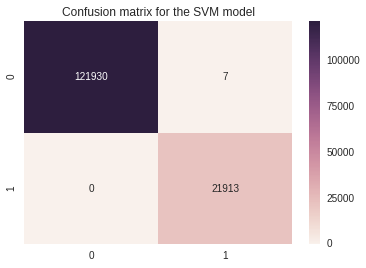

In [59]:
title = 'Confusion matrix for the SVM model'
plt.title(title);
#Plotting the confusion matrix.
sns.heatmap(svm_svc_conf_matrix, annot=True,  fmt='')